## Certified AI Practitioner Week 02 Call 01 - Train and Evaluate in the Cloud

## Learning Objectives

- Create SageMaker Studio resources programmatically using CloudFormation
- Upload data and artifacts to S3 for use with SageMaker
- Use SageMaker to train a scikit-learn model from a training script
- View and interpret model performance from CloudWatch logs
- Explain and interpret confusion matrices and feature importance
- Understand how IAM roles and S3 permissions enable secure ML workflows
- Automate model training using the SKLearn Estimator API

## Why Train in the Cloud?

Local notebooks are great for prototyping, but they don’t scale well when working with real-world machine learning workflows. As datasets grow and model complexity increases, training on your laptop becomes slow, inconsistent, and hard to reproduce.

By using **Amazon SageMaker**, we get:

- **Scalability** - Choose from dozens of instance types to train faster  
- **Reproducibility** - Jobs are tracked, versioned, and logged  
- **Separation of concerns** - Training logic is decoupled from local development  
- **Artifact storage** - Models are automatically saved to S3 for reuse  
- **Built-in monitoring** - Logs are streamed to CloudWatch for debugging and analysis

In this session, we’ll shift from training locally to launching a fully managed training job in the cloud.


## Infrastructure Setup with CloudFormation

To train models in SageMaker Studio, we first need to provision the necessary infrastructure.

In this step, we’ll use an automated **CloudFormation template** to create:

- A **SageMaker Studio domain** for running cloud-based notebooks  
- An **IAM execution role** with S3 and SageMaker permissions  
- A dedicated **S3 bucket** to store training data and model artifacts  

Instead of clicking through the AWS Console, we’ll deploy this setup programmatically using `boto3`. The stack will output everything you need - including the bucket name and role ARN - to use in the next steps of this notebook.

In [3]:
import boto3
import json

def stack_exists(name):
    try:
        cf.describe_stacks(StackName=name)
        return True
    except cf.exceptions.ClientError as e:
        if "does not exist" in str(e):
            return False
        raise  # re-raise any unexpected error

def deploy_stack(stack_name, template_body, parameters):
    if stack_exists(stack_name):
        print(f"🔄 Updating stack: {stack_name}")
        try:
            response = cf.update_stack(
                StackName=stack_name,
                TemplateBody=template_body,
                Parameters=parameters,
                Capabilities=["CAPABILITY_NAMED_IAM"]
            )
            waiter = cf.get_waiter("stack_update_complete")
        except cf.exceptions.ClientError as e:
            if "No updates are to be performed" in str(e):
                print("✅ No changes detected.")
                return
            else:
                raise
    else:
        print(f"🚀 Creating stack: {stack_name}")
        response = cf.create_stack(
            StackName=stack_name,
            TemplateBody=template_body,
            Parameters=parameters,
            Capabilities=["CAPABILITY_NAMED_IAM"]
        )
        waiter = cf.get_waiter("stack_create_complete")

    print(f"⏳ Waiting for {stack_name} to complete...")
    waiter.wait(StackName=stack_name)
    print("✅ Stack operation completed.")

    # Print outputs
    outputs = cf.describe_stacks(StackName=stack_name)["Stacks"][0]["Outputs"]
    print("🔧 Stack Outputs:")
    print(json.dumps({o["OutputKey"]: o["OutputValue"] for o in outputs}, indent=2))

ec2 = boto3.client("ec2")
cf = boto3.client("cloudformation")

# Get the default VPC ID
vpc_id = ec2.describe_vpcs(Filters=[{"Name": "isDefault", "Values": ["true"]}])["Vpcs"][0]["VpcId"]

# Get a public subnet ID in that VPC
subnets = ec2.describe_subnets(Filters=[{"Name": "vpc-id", "Values": [vpc_id]}])
subnet_id = subnets["Subnets"][0]["SubnetId"]

# Load your template
with open("cf_templates/sagemaker_infra.yaml") as f:
    template_body = f.read()

bucketNameSuffix = "zali"
stack_name = "caip02-cloud-ml-stack"

parameters = [
    {"ParameterKey": "BucketNameSuffix", "ParameterValue": bucketNameSuffix},
    {"ParameterKey": "VpcId", "ParameterValue": vpc_id},
    {"ParameterKey": "SubnetId", "ParameterValue": subnet_id}
]

deploy_stack(stack_name, template_body, parameters)


🚀 Creating stack: caip02-cloud-ml-stack
⏳ Waiting for caip02-cloud-ml-stack to complete...
✅ Stack operation completed.
🔧 Stack Outputs:
{
  "StudioUserName": "caip02-user",
  "BucketName": "caip02-ml-bucket-zali",
  "DomainId": "d-engxnmjfm6da",
  "RoleArn": "arn:aws:iam::458806987020:role/caip02-execution-role-zali"
}


## Prepare Titanic Data

In this step, we’ll clean and preprocess the Titanic dataset using the same logic we applied in Week 1. This prepares the data for training in SageMaker.

We will:

- Load both training and test CSVs from Kaggle  
- Combine them into a single DataFrame  
- Select relevant features  
- Drop rows with missing values (for simplicity)  
- Encode categorical columns (`Sex`, `Embarked`) as numeric values  
- Save the cleaned dataset as `cleaned_titanic.csv`


In [6]:
import pandas as pd

# Load Titanic training and test datasets
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Combine them into one DataFrame
df = pd.concat([df_train, df_test], ignore_index=True)

# Select relevant columns
cols = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
df = df[cols]

# Drop rows with missing values (simplified approach)
df = df.dropna()

# Encode categorical features
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
df["Embarked"] = df["Embarked"].map({"S": 0, "C": 1, "Q": 2})

# Final preview
print("\nCleaned preview:")
display(df.head())

# Save cleaned dataset
df.to_csv("cleaned_titanic.csv", index=False)
print("Saved cleaned_titanic.csv")



Cleaned preview:


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3,0,22.0,1,0,7.2500,0
1,1.0,1,1,38.0,1,0,71.2833,1
2,1.0,3,1,26.0,0,0,7.9250,0
3,1.0,1,1,35.0,1,0,53.1000,0
4,0.0,3,0,35.0,0,0,8.0500,0


Saved cleaned_titanic.csv


## Upload Data to S3

Now that we’ve prepared the Titanic dataset, we’ll upload it to our dedicated S3 bucket so it can be used by SageMaker for training.

Make sure you’re using the bucket created by your CloudFormation stack. You can retrieve it from the stack outputs or hardcode it here for now.

In [7]:
import boto3

bucket_name = "caip02-ml-bucket-zali"  # Replace with your actual bucket name if needed
key = "inputs/cleaned_titanic.csv"

s3 = boto3.client("s3")
s3.upload_file("cleaned_titanic.csv", bucket_name, key)

print(f"Uploaded cleaned_titanic.csv to s3://{bucket_name}/{key}")


Uploaded cleaned_titanic.csv to s3://caip02-ml-bucket-zali/inputs/cleaned_titanic.csv


## Write the Training Script (train_model.py)

SageMaker training jobs run inside isolated containers. Instead of writing code cell by cell, we’ll create a standalone script that SageMaker will execute in the cloud.

This script will:

- Load the Titanic dataset from the input channel
- Train a Decision Tree model
- Evaluate performance using a confusion matrix and classification report
- Print feature importances
- Save the trained model to the `/opt/ml/model/` directory for SageMaker to capture

We’ll save this script locally so we can pass it into a SageMaker training job.

In [8]:
from IPython.display import Markdown, display

def show_code(filepath):
    with open(filepath, "r") as f:
        code = f.read()
    display(Markdown(f"```python\n{code}\n```"))

# Call this after writing the file
show_code("train_model.py")


```python
import pandas as pd
import joblib
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

def main():
    # SageMaker passes input as /opt/ml/input/data/train/
    input_path = "/opt/ml/input/data/train/cleaned_titanic.csv"
    df = pd.read_csv(input_path)

    # Split features and target
    X = df.drop("Survived", axis=1)
    y = df["Survived"]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = clf.predict(X_test_scaled)

    print("\n=== Classification Report ===\n")
    print(classification_report(y_test, y_pred))

    print("\n=== Confusion Matrix ===\n")
    print(confusion_matrix(y_test, y_pred))

    print("\n=== Feature Importances ===\n")
    importances = pd.Series(clf.feature_importances_, index=X.columns)
    print(importances.sort_values(ascending=False))

    # Save model
    os.makedirs("/opt/ml/model", exist_ok=True)
    joblib.dump(clf, "/opt/ml/model/model.joblib")

if __name__ == "__main__":
    main()

```

## Launch a SageMaker Training Job

Now that our training script is ready and the data is uploaded to S3, we’ll launch a managed training job using SageMaker.

We’ll use the **SKLearn Estimator**, which runs our `train_model.py` script inside a pre-built scikit-learn container. SageMaker will automatically:

- Mount our data from S3 into the container
- Run the training script
- Capture logs in CloudWatch
- Save the trained model artifact to our specified S3 output path

Once the job completes, we’ll review the logs and retrieve the model if needed.

### Why Use the SKLearn Estimator?

The `SKLearn` Estimator is ideal for training traditional machine learning models (like decision trees) using **scikit-learn**. It lets us:

- Run our local Python script without modification  
- Avoid building Docker containers  
- Focus on modeling, not infrastructure  
- Use pre-configured SageMaker environments that match local development

---

### What Are the Alternatives?

SageMaker provides several Estimators for different use cases:

| Estimator | Use Case | Why We’re Not Using It |
|----------|----------|-------------------------|
| `SKLearn` | Scikit-learn models | ✅ Perfect for this training job |
| `XGBoost` | Gradient boosting for tabular data | ❌ Great for next step, but we’re starting simple |
| `TensorFlow` / `PyTorch` | Deep learning / neural networks | ❌ Overkill for decision trees |
| `Estimator` (Generic) | Custom Docker containers | ❌ Too complex for this call |
| `ScriptProcessor` | Preprocessing scripts (no model training) | ❌ We’re training a model, not just processing data |

This flexibility is one of the key strengths of SageMaker — we can start simple, and scale up when needed.

In [11]:
from sagemaker.sklearn.estimator import SKLearn
import sagemaker
import boto3

# Values from your CloudFormation stack
bucket = "caip02-ml-bucket-zali"
role = "arn:aws:iam::458806987020:role/caip02-execution-role-zali"
region = boto3.Session().region_name

# Input and output locations in S3
input_path = f"s3://{bucket}/inputs/"
output_path = f"s3://{bucket}/models/"

# Set up the SageMaker session
session = sagemaker.Session()

# Create SKLearn estimator
estimator = SKLearn(
    entry_point="train_model.py",
    role=role,
    instance_type="ml.m5.large",
    framework_version="1.0-1",
    sagemaker_session=session,
    output_path=output_path,
    base_job_name="titanic-decision-tree"
)

# Launch the training job
estimator.fit({"train": input_path})


sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\Ziggy\AppData\Local\sagemaker\sagemaker\config.yaml


INFO:sagemaker:Creating training-job with name: titanic-decision-tree-2025-10-27-23-29-54-142


2025-10-27 23:29:56 Starting - Starting the training job...
2025-10-27 23:30:34 Downloading - Downloading input data..
2025-10-27 23:31:04 Downloading - Downloading the training image.....2025-10-27 23:32:07,844 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-10-27 23:32:07,848 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-10-27 23:32:07,852 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-10-27 23:32:07,872 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-10-27 23:32:08,148 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-10-27 23:32:08,153 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-10-27 23:32:08,176 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-10-27 23:32:08,180 sagemaker-training-toolkit INF

### Example Output (Sagemaker Jobs Training Screenshot)

<div align="center">
  <img src="sm_jobs_training.png" alt="Sagemaker Jobs Training Dashboard" style="width:100%;">
</div>

## Review Results in CloudWatch

After the SageMaker training job completes, the output of our `train_model.py` script is automatically sent to **Amazon CloudWatch Logs**. This includes:

- The full **classification report**
- The **confusion matrix** showing predicted vs actual survival
- A list of **feature importances** ranked by influence on model predictions

These logs are essential for debugging and evaluating model performance — especially when training at scale or remotely.

---

### How to View the Logs

1. Go to the [SageMaker Console](https://console.aws.amazon.com/sagemaker/home)
2. Click **Training jobs**
3. Select your job name (e.g., `titanic-decision-tree-...`)
4. Scroll down to **Monitor** and click the **View logs** link
5. Inside CloudWatch Logs, review the printed output from your training script

---

### Example Output (CloudWatch Screenshot)

<div align="center">
  <img src="cw_logs.png" alt="CloudWatch output" style="width:80%;">
</div>

---

This output confirms that your training script executed properly and gives you quick insights into model quality — without downloading any files.


## Local Model Evaluation (For Comparison)

Before we trained the model in SageMaker, we could have easily done the same thing locally. This helps us validate that our cloud workflow is working correctly by comparing the same model trained and evaluated in a Jupyter cell.

This block repeats the core logic of our `train_model.py` file but runs right here in the notebook.

You should see the same confusion matrix and feature importance values if everything is consistent.


=== Classification Report ===

              precision    recall  f1-score   support

         0.0       0.80      0.90      0.84       106
         1.0       0.81      0.67      0.73        72

    accuracy                           0.80       178
   macro avg       0.81      0.78      0.79       178
weighted avg       0.80      0.80      0.80       178



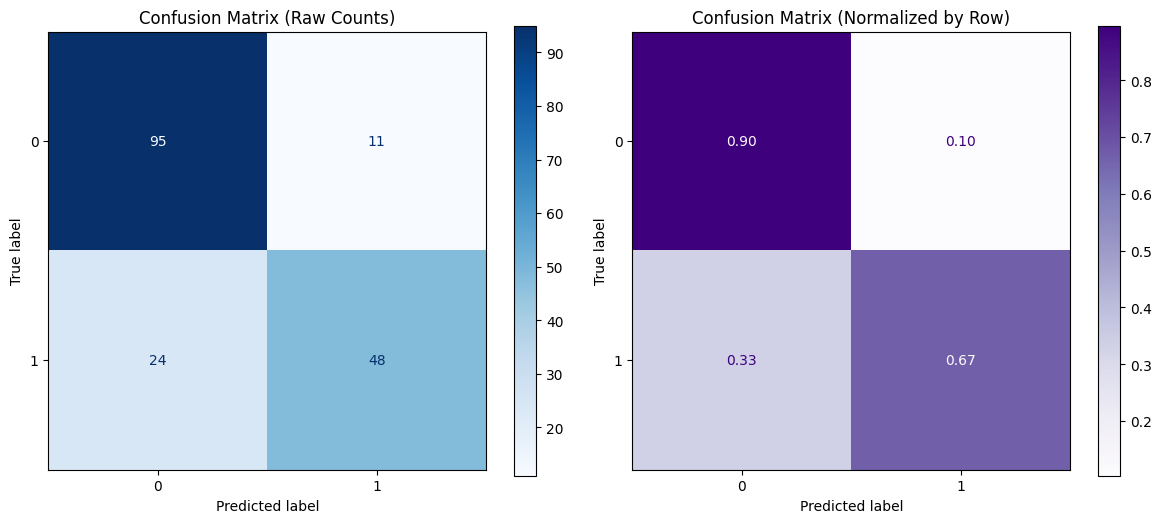

C:\Users\Ziggy\AppData\Local\Temp\ipykernel_66228\953728735.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette="viridis")


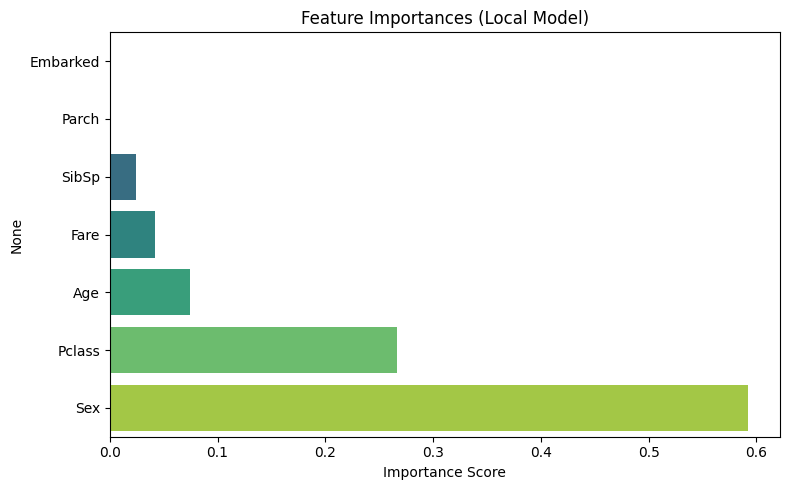

In [26]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned Titanic dataset
df = pd.read_csv("cleaned_titanic.csv")

# Features and target
X = df.drop("Survived", axis=1)
y = df["Survived"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_scaled)

print("=== Classification Report ===\n")
print(classification_report(y_test, y_pred))

# Raw and normalized confusion matrices
cm_raw = confusion_matrix(y_test, y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

# Plot both side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw counts
ConfusionMatrixDisplay(confusion_matrix=cm_raw).plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("Confusion Matrix (Raw Counts)")

# Normalized
ConfusionMatrixDisplay(confusion_matrix=cm_norm).plot(ax=axes[1], cmap='Purples', values_format=".2f")
axes[1].set_title("Confusion Matrix (Normalized by Row)")

plt.tight_layout()
plt.show()

# Feature importance plot
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=importances.index, palette="viridis")
plt.title("Feature Importances (Local Model)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


### From Sagemaker Training

<div align="center">
  <img src="cw_logs.png" alt="CloudWatch output" style="width:80%;">
</div>

## Cleanup

Now that you've successfully trained and evaluated a model in the cloud, you’ve completed your first end-to-end managed ML workflow using SageMaker.

---

### Cleanup (Don’t Leave the Lights On)

To avoid unnecessary AWS charges, we’ll delete all the resources we created:

- **CloudFormation Stack**:  
  This will automatically delete:
  - The SageMaker Studio domain
  - The execution role
  - The S3 bucket  
  You can do this programmatically using `boto3` (recommended), or…  
  *if you absolutely must*... use the [CloudFormation Console](https://console.aws.amazon.com/cloudformation) like a savage.

- **CloudWatch Logs**:  
  These are optional to clean up, but can be removed from the [CloudWatch Console](https://console.aws.amazon.com/cloudwatch) if desired.



In [ ]:
import boto3

cf = boto3.client("cloudformation")
stack_name = "caip02-cloud-ml-stack"

def delete_stack_and_wait(stack_name):
    print(f"🧨 Deleting stack: {stack_name}")
    
    # Initiate deletion
    cf.delete_stack(StackName=stack_name)

    # Wait until stack deletion is complete
    waiter = cf.get_waiter("stack_delete_complete")
    print("⏳ Waiting for stack to be fully deleted...")
    waiter.wait(StackName=stack_name)

    print(f"✅ Stack '{stack_name}' successfully deleted.")

# Call it
delete_stack_and_wait(stack_name)


🧨 Deleting stack: caip02-cloud-ml-stack
⏳ Waiting for stack to be fully deleted...
✅ Stack 'caip02-cloud-ml-stack' successfully deleted.


: 

## Wrap-Up & Takeaways 

In this notebook, you completed your first end-to-end cloud-based ML workflow using Amazon SageMaker. You:

- Created a fully managed SageMaker Studio environment using CloudFormation
- Cleaned and prepared the Titanic dataset
- Wrote a training script (`train_model.py`) that runs in the cloud
- Uploaded your data to S3
- Launched a training job with the SKLearn Estimator
- Viewed evaluation results (confusion matrix, classification report, feature importances) in CloudWatch
- Compared cloud output with a local model to validate consistency
- Cleaned up your resources programmatically using `boto3`

---

This workflow reflects what real ML teams do in production:

- Automate infra with Infrastructure-as-Code (IaC)
- Package training logic into standalone scripts
- Submit scalable, trackable jobs in the cloud
- Monitor outputs in centralized logs
- Maintain reproducibility between local dev and cloud runs
